In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import json
import os
import re
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [3]:
### Read representative cells
# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_L2_repcells_loginv_Harmony_noZ.h5ad")
# adata_all = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_Harmony_test_no_scale.h5ad")
adata_all = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
print('Original adata:', adata_all.shape)
label = adata_all.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)

Original adata: (161764, 33538)
all cell types: ['ASDC', 'B intermediate', 'B memory', 'B naive', 'CD14 Mono', 'CD16 Mono', 'CD4 CTL', 'CD4 Naive', 'CD4 Proliferating', 'CD4 TCM', 'CD4 TEM', 'CD8 Naive', 'CD8 Proliferating', 'CD8 TCM', 'CD8 TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK Proliferating', 'NK_CD56bright', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


In [16]:
Hao_genes = adata_all.var_names.tolist()
len(Hao_genes)

33538

## Fisher exact test

In [17]:
import scipy.stats as stats

def perform_fisher_test(PreLect_genes, ACT_genes, Hao_genes):
    """
    Performs Fisher's exact test on the provided gene sets.

    Parameters:
    - PreLect_genes: Set of genes in PreLect_genes.
    - ACT_genes: Set of genes in ACT_genes.
    - Hao_genes: Set of all genes in Hao_genes (background population).

    Returns:
    - oddsratio: The odds ratio calculated from the contingency table.
    - p_value: The p-value from Fisher's exact test.
    """
    # Ensure the inputs are sets
    PreLect_genes = set(PreLect_genes)
    ACT_genes = set(ACT_genes)
    Hao_genes = set(Hao_genes)

    # Calculate the counts for the contingency table
    a = len(PreLect_genes & ACT_genes)                   # Genes in both PreLect_genes and ACT_genes
    b = len(PreLect_genes - ACT_genes)                   # Genes in PreLect_genes but not in ACT_genes
    c = len(ACT_genes - PreLect_genes)                   # Genes in ACT_genes but not in PreLect_genes
    d = len(Hao_genes - (PreLect_genes | ACT_genes))     # Genes in neither gene set

    # Construct the contingency table
    contingency_table = [[a, b],
                         [c, d]]

    # Perform Fisher's exact test
    oddsratio, p_value = stats.fisher_exact(contingency_table)

    # Output the results
    print("Contingency Table:")
    print(f"                   In ACT_genes    Not in ACT_genes")
    print(f"In PreLect_genes       {a}               {b}")
    print(f"Not in PreLect_genes   {c}            {d}")
    print(f"\nOdds Ratio: {oddsratio}")
    print(f"P-value: {p_value}")

    return oddsratio, p_value

# OR > 1: 
#   Indicates a positive association between being in PreLect_genes and being in ACT_genes
#   Genes in PreLect_genes are more likely to be in ACT_genes compared to genes not in PreLect_genes
#   The higher the OR, the stronger the positive association between PreLect_genes and ACT_genes


## Read ACT markers

In [4]:
# marker_df = pd.read_csv('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level2/ACT_annotation/Human_blood_marker_processed.csv')
# marker_df = pd.read_csv(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\ACT_annotation\Human_blood_marker_processed.csv")
marker_df = pd.read_csv(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/ACT_annotation/Human_blood_marker_processed.csv')
print(marker_df.shape)
marker_df.head()

(147, 6)


,Species,Tissue,super_type,CellType,Marker,Resource
0,Human,Blood,B,Activated B cell,"CD5, MIR155HG, TAGLN2","35025971, 28910360, 2474446"
1,Human,Blood,T_CD4,"Activated CD4-positive, alpha-beta T cell","CD4, CCR6, CD14, CD19, CD38, CD3D, CD3G, CD69,...","35381424, 32783921, 35831277, 34529726, 103413..."
2,Human,Blood,T_CD4,"Activated CD4-positive, CD25-positive, CCR4-po...","CD3D, CD3E, CD3G, CD4, FOXP3",30977974
3,Human,Blood,NaN,Adult endothelial progenitor cell,"KDR, PROM1, CD34, PTPRC, PECAM1, CD14","27561827, 29391882, 24641802, 29147957, 267700..."
4,Human,Blood,T,Alpha-beta T cell,"CD3D, CD3E, CD3G, IL7R","34284174, 28777444"


In [19]:
def get_celltype_marker(name, marker_df):
    string = marker_df[marker_df['CellType'] == name]['Marker'].tolist()[0]  # Erythrocyte Platelet?
    marker_set = set(string.split(', '))
    return marker_set

In [20]:
clus_name_pairs = [
    ('B_memory', 'Memory B cell'),
    ('B_naive', 'Naive B cell'),
    ('CD14_Mono', 'Classical monocyte'),
    ('CD16_Mono', 'Non-classical monocyte'),
    ('CD4_Proliferating', 'Proliferating CD4-positive, alpha-beta T cell'),
    ('CD4_TCM', 'Central memory CD4-positive, alpha-beta T cell'),
    ('CD4_TEM', 'Effector memory CD4-positive, alpha-beta T cell'),
    ('CD8_Naive', 'Naive thymus-derived CD8-positive, alpha-beta T cell'),
    ('CD8_TEM', 'Effector memory CD8-positive, alpha-beta T cell'),
    ('cDC1', 'Type 1 conventional dendritic cell'),
    ('cDC2', 'Type 2 conventional dendritic cell'),
    ('gdT', 'Gamma-delta T cell'),
    ('HSPC', 'Hematopoietic stem cell'),
    ('MAIT', 'Mucosal invariant T cell'),
    ('pDC', 'Plasmacytoid dendritic cell'),
    ('Treg', 'Regulatory T cell'),
    ('CD4_CTL', 'CD4-positive, alpha-beta cytotoxic T cell'),
    ('CD4_Naive', 'Naive thymus-derived CD4-positive, alpha-beta T cell'),
    ('CD8_TCM', 'Central memory CD8-positive, alpha-beta T cell'),
    ('Plasmablast', 'Plasmablast'), 
    # More than 20 L2 celltypes
    ('Eryth', 'Erythrocyte'), 
    ('NK', 'Natural killer cell'), 
    ('NK_CD56bright', 'CD16-negative, CD56-bright natural killer cell, human'), 
    ('Platelet', 'Platelet')
    ## ACT not defined
    # ASDC
    # B_intermediate
    # CD8_Proliferating
    # Doublet
    # ILC
    # NK_Proliferating
    # dnT
]
cluster_2_ACT_name = dict(clus_name_pairs)
cluster_2_ACT_name

{'B_memory': 'Memory B cell',
 'B_naive': 'Naive B cell',
 'CD14_Mono': 'Classical monocyte',
 'CD16_Mono': 'Non-classical monocyte',
 'CD4_Proliferating': 'Proliferating CD4-positive, alpha-beta T cell',
 'CD4_TCM': 'Central memory CD4-positive, alpha-beta T cell',
 'CD4_TEM': 'Effector memory CD4-positive, alpha-beta T cell',
 'CD8_Naive': 'Naive thymus-derived CD8-positive, alpha-beta T cell',
 'CD8_TEM': 'Effector memory CD8-positive, alpha-beta T cell',
 'cDC1': 'Type 1 conventional dendritic cell',
 'cDC2': 'Type 2 conventional dendritic cell',
 'gdT': 'Gamma-delta T cell',
 'HSPC': 'Hematopoietic stem cell',
 'MAIT': 'Mucosal invariant T cell',
 'pDC': 'Plasmacytoid dendritic cell',
 'Treg': 'Regulatory T cell',
 'CD4_CTL': 'CD4-positive, alpha-beta cytotoxic T cell',
 'CD4_Naive': 'Naive thymus-derived CD4-positive, alpha-beta T cell',
 'CD8_TCM': 'Central memory CD8-positive, alpha-beta T cell',
 'Plasmablast': 'Plasmablast',
 'Eryth': 'Erythrocyte',
 'NK': 'Natural killer cel

In [21]:
len(cluster_2_ACT_name)

24

## For all types

In [22]:
def various_lmbd_PreLect_vs_ACT_fisher(celltype, ACT_genes, Hao_genes):
    # Define the regular expression pattern using the celltype variable
    pattern = re.compile(r'^{}_([0-9\.eE+-]+)_features\.txt$'.format(celltype))
    # start with B_, followed by a number (which can include digits, decimal points, signs, and exponential notation), and end with _features.txt

    # Under the celltype, get the feature set of different lambdas
    filenames = os.listdir()
    matching_files = [filename for filename in filenames if pattern.match(filename)]

    fisher_result = pd.DataFrame(columns=['Lambda', 'Feature_no', 'Odds_ratio', 'P-value'])
    
    for file in matching_files:
        print('=====')
        lmbd = float(file.split('_')[-2])
        print(lmbd)
        try:
            feature_df = pd.read_csv(file, names=['Gene', 'Weight', 'Tendency'], sep='\t')
            PreLect_genes_at_lmbd = feature_df['Gene'].tolist()
        except:
            print('File not exist:', file)
            continue
        print('PreLect feature no:', len(PreLect_genes_at_lmbd))
        OR, p_v = perform_fisher_test(PreLect_genes_at_lmbd, ACT_genes, Hao_genes)
        fisher_result = pd.concat([fisher_result, pd.DataFrame({'Lambda': [lmbd], 
                                                                'Feature_no': [len(PreLect_genes_at_lmbd)], 
                                                                'Odds_ratio': [OR], 
                                                                'P-value': [p_v]})])
    
    return fisher_result

In [ ]:
# os.chdir(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\large_lambda_various\at_various_number\features_at_various_no')
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level2/large_lambda_various/at_various_number/features_at_various_no')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/large_lambda_various/at_various_number/features_at_various_no')

# output_path = r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\large_lambda_various\L2_fisher_result_v2"
output_path = source_code_dir / 'PBMC_Hao_batch_noZ/Level2/large_lambda_various/L2_fisher_result_v2'

for clus, name in cluster_2_ACT_name.items():
    ACT_genes_celltype = get_celltype_marker(name, marker_df)
    # ACT_genes: remove any that are not part of Hao_genes
    ACT_genes_celltype = set(ACT_genes_celltype).intersection(set(Hao_genes))
    print('==========')
    print(f'{clus}, ACT markers no:', len(ACT_genes_celltype))

    fisher_result = various_lmbd_PreLect_vs_ACT_fisher(clus, ACT_genes_celltype, Hao_genes)
    fisher_result = fisher_result.sort_values('Feature_no')
    print(fisher_result)
    fisher_result.to_csv(os.path.join(output_path, f'{clus}_fisher_result.csv'))

B_memory, ACT markers no: 17
=====
0.0002154434690031884
PreLect feature no: 210
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       5               205
Not in PreLect_genes   12            33316

Odds Ratio: 67.71544715447155
P-value: 5.341464613484603e-08
=====
0.00046415888336127795
PreLect feature no: 120
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       5               115
Not in PreLect_genes   12            33406

Odds Ratio: 121.03623188405797
P-value: 3.2235725112900656e-09
=====
0.0010000000000000002
PreLect feature no: 56
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       4               52
Not in PreLect_genes   13            33469

Odds Ratio: 198.04142011834318
P-value: 1.6319968523977436e-08
=====
0.0021544346900318843
PreLect feature no: 31
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       3         

C:\Users\evanlee\AppData\Local\Temp\ipykernel_58952\3578514806.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fisher_result = pd.concat([fisher_result, pd.DataFrame({'Lambda': [lmbd],
C:\Users\evanlee\AppData\Local\Temp\ipykernel_58952\3578514806.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fisher_result = pd.concat([fisher_result, pd.DataFrame({'Lambda': [lmbd],
C:\Users\evanlee\AppData\Local\Temp\ipykernel_58952\3578514806.py:24: FutureWarning: The behavior of DataFrame concatena

PreLect feature no: 33
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       3               30
Not in PreLect_genes   0            33505

Odds Ratio: inf
P-value: 8.678666100154346e-10
=====
0.00046415888336127795
PreLect feature no: 23
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       3               20
Not in PreLect_genes   0            33515

Odds Ratio: inf
P-value: 2.817067020413003e-10
=====
0.0006812920690579617
PreLect feature no: 18
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       2               16
Not in PreLect_genes   1            33519

Odds Ratio: 4189.875
P-value: 8.159116863296425e-07
=====
0.0014677992676220694
PreLect feature no: 12
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       3               9
Not in PreLect_genes   0            33526

Odds Ratio: inf
P-value: 3.49946213715901e-11
     Lam

C:\Users\evanlee\AppData\Local\Temp\ipykernel_58952\3578514806.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fisher_result = pd.concat([fisher_result, pd.DataFrame({'Lambda': [lmbd],
C:\Users\evanlee\AppData\Local\Temp\ipykernel_58952\3578514806.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fisher_result = pd.concat([fisher_result, pd.DataFrame({'Lambda': [lmbd],
C:\Users\evanlee\AppData\Local\Temp\ipykernel_58952\3578514806.py:24: FutureWarning: The behavior of DataFrame concatena

PreLect feature no: 28
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       8               20
Not in PreLect_genes   25            33485

Odds Ratio: 535.76
P-value: 1.0735974288738039e-18
=====
0.0021544346900318843
PreLect feature no: 18
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       5               13
Not in PreLect_genes   28            33492

Odds Ratio: 460.05494505494505
P-value: 5.7008284335621655e-12
=====
0.004641588833612781
PreLect feature no: 15
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       4               11
Not in PreLect_genes   29            33494

Odds Ratio: 419.98746081504703
P-value: 1.0517255772819356e-09
=====
0.010000000000000004
PreLect feature no: 14
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       3               11
Not in PreLect_genes   30            33494

Odds Ratio: 304.49090

C:\Users\evanlee\AppData\Local\Temp\ipykernel_58952\3578514806.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fisher_result = pd.concat([fisher_result, pd.DataFrame({'Lambda': [lmbd],
C:\Users\evanlee\AppData\Local\Temp\ipykernel_58952\3578514806.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fisher_result = pd.concat([fisher_result, pd.DataFrame({'Lambda': [lmbd],
C:\Users\evanlee\AppData\Local\Temp\ipykernel_58952\3578514806.py:24: FutureWarning: The behavior of DataFrame concatena

PreLect feature no: 40
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       2               38
Not in PreLect_genes   2            33496

Odds Ratio: 881.4736842105264
P-value: 8.309179001616623e-06
=====
0.0021544346900318843
PreLect feature no: 26
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       1               25
Not in PreLect_genes   3            33509

Odds Ratio: 446.7866666666667
P-value: 0.00309749436462445
=====
0.004641588833612781
PreLect feature no: 15
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       1               14
Not in PreLect_genes   3            33520

Odds Ratio: 798.0952380952381
P-value: 0.0017878954995477067
=====
0.010000000000000004
PreLect feature no: 8
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       1               7
Not in PreLect_genes   3            33527

Odds Ratio: 1596.523809

In [24]:
l2_colors = adata_all.uns['celltype.l2_colors']
l2_colors

array(['#ffff00', '#1ce6ff', '#ff34ff', '#ff4a46', '#008941', '#006fa6',
       '#a30059', '#ffdbe5', '#7a4900', '#0000a6', '#63ffac', '#b79762',
       '#004d43', '#8fb0ff', '#997d87', '#5a0007', '#809693', '#6a3a4c',
       '#1b4400', '#4fc601', '#3b5dff', '#4a3b53', '#ff2f80', '#61615a',
       '#ba0900', '#6b7900', '#00c2a0', '#ffaa92', '#ff90c9', '#b903aa',
       '#d16100'], dtype=object)

In [25]:
from matplotlib import cm
tab20 = cm.get_cmap('tab20').colors
color_count = 0

C:\Users\evanlee\AppData\Local\Temp\ipykernel_58952\2709456469.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab20 = cm.get_cmap('tab20').colors


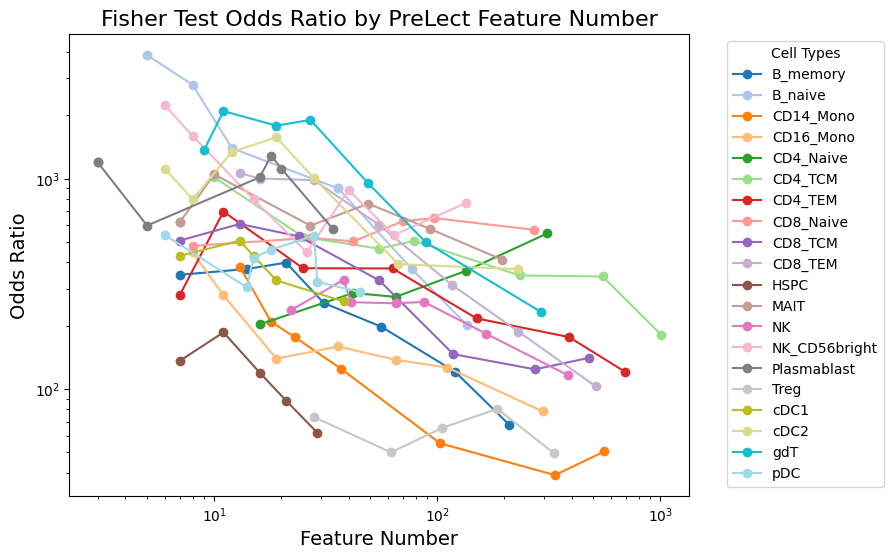

In [ ]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\large_lambda_various\L2_fisher_result_v2")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/large_lambda_various/L2_fisher_result_v2')
color_count = 0
plt.figure(figsize=(8, 6))

# queue = ['B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_TEM', 'cDC1', 'cDC2', 'gdT', 'HSPC', 'MAIT', 'pDC', 'Treg', 'CD4_CTL', 'CD4_Naive', 'CD8_TCM', 'Plasmablast', 'Eryth', 'NK', 'NK_CD56bright', 'Platelet']
queue = ['B_memory',
                  'B_naive',  # previous result single
                    'CD14_Mono',
                    'CD16_Mono',
                    'CD4_Naive',
                    'CD4_TCM',
                    'CD4_TEM',
                    'CD8_Naive',
                    'CD8_TCM',
                    'CD8_TEM',
                    'HSPC',
                    'MAIT',
                    'NK',
                    'NK_CD56bright',
                    'Plasmablast',
                    'Treg',
                    'cDC1',
                    'cDC2',   # previous result single
                    'gdT',
                    'pDC']
for i, celltype in enumerate(queue):
    # if celltype in ['CD4_CTL', 'CD4_Proliferating']:
    #     # Odds ratio = INF when feature number are few
    #     print('Skipping', celltype)
    #     continue
    try:
        fisher_result = pd.read_csv(f'{celltype}_fisher_result.csv', index_col=0)
        if fisher_result.empty:
            print('Result empty', celltype)
            continue
        elif len(fisher_result) == 1:
            print('Result single lambda', celltype)
            continue
    except:
        print('No file', celltype)
        continue
    
    # plt.plot(fisher_result['Feature_no'], fisher_result['Odds_ratio'], marker='o', label=celltype, color=l2_colors[i])
    plt.plot(fisher_result['Feature_no'], fisher_result['Odds_ratio'], marker='o', label=celltype, color=tab20[color_count])
    color_count += 1

plt.xlabel('Feature Number', fontsize=14)
plt.ylabel('Odds Ratio', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.title('Fisher Test Odds Ratio by PreLect Feature Number', fontsize=16)
plt.legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

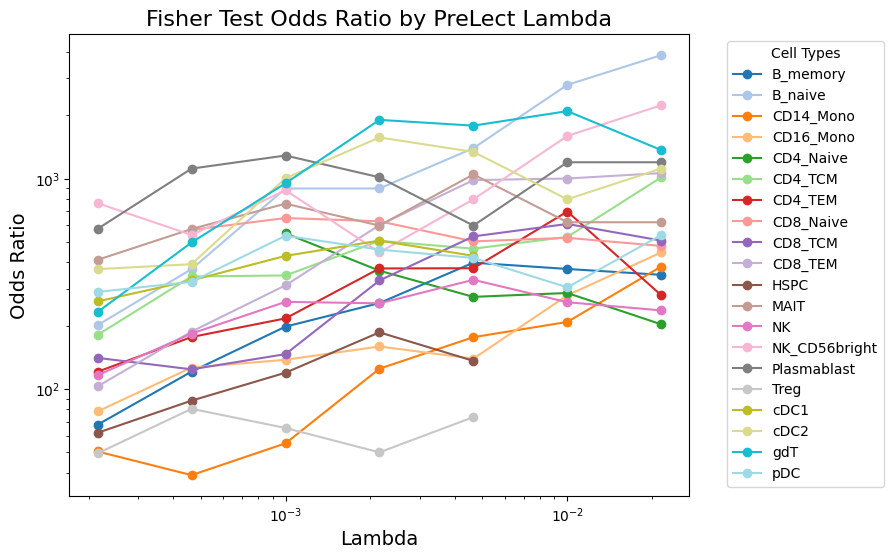

In [27]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\large_lambda_various\L2_fisher_result")

color_count = 0
plt.figure(figsize=(8, 6))
for i, celltype in enumerate(queue):
    # if celltype in ['CD4_CTL', 'CD4_Proliferating']:
    #     print('Skipping', celltype)
    #     continue
    # if celltype not in ['HSPC', 'Treg', 'cDC1', 'CD14_Mono']: continue
    try:
        fisher_result = pd.read_csv(f'{celltype}_fisher_result.csv', index_col=0)
        fisher_result = fisher_result.sort_values(by='Lambda', ascending=True)
        if fisher_result.empty:
            print('Result empty', celltype)
            continue
        elif len(fisher_result) == 1:
            print('Result single lambda', celltype)
            continue
    except:
        print('No file', celltype)
        continue
    
    # plt.plot(fisher_result['Lambda'], fisher_result['Odds_ratio'], marker='o', label=celltype, color=l2_colors[i])
    plt.plot(fisher_result['Lambda'], fisher_result['Odds_ratio'], marker='o', label=celltype, color=tab20[color_count])
    color_count += 1
    for i, row in fisher_result.iterrows():
        if row['Odds_ratio'] == 0:
            print(celltype, row['Lambda'])

plt.xlabel('Lambda', fontsize=14)
plt.ylabel('Odds Ratio', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.title('Fisher Test Odds Ratio by PreLect Lambda', fontsize=16)
plt.legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()